In [1]:
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from tqdm import tqdm

from bikebench.rendering import animation

from bikebench.data_loading import data_loading
from bikebench.conditioning import conditioning
from bikebench.design_evaluation import design_evaluation

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Using java as the Java binary


/home/mileva/mambaforge/envs/bike-bench-cuda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = data_loading.load_bike_bench_train()
data_variance = torch.tensor(data.var().values, device=device, dtype=torch.float32)

In [3]:
evaluators = [design_evaluation.AestheticsEvaluator("Text", device=device), design_evaluation.ValidationEvaluator(device=device)]
evaluator, requirement_names, is_objective, is_conditional = design_evaluation.construct_tensor_evaluator(evaluators, data.columns)

condition = {"Text": "cyberpunk racing bike in mauve"}

In [4]:
with torch.no_grad():
    baseline_scores = evaluator(torch.tensor(data.values, dtype=torch.float32, device=device), condition)
score_std = baseline_scores.std(dim=0)

In [5]:
torch.tensor(data.values[0:1], dtype=torch.float32, device=device).shape

torch.Size([1, 87])

In [6]:
score = evaluator(torch.tensor(data.values, dtype=torch.float32, device=device), condition)

In [7]:
# 1–99th percentile box per column
q = data.quantile([0.01, 0.99])
min_values = torch.tensor(q.loc[0.01].values, dtype=torch.float32, device=device)
max_values = torch.tensor(q.loc[0.99].values, dtype=torch.float32, device=device)


In [8]:
# make sure this tensor is a leaf with grads
data_gd = torch.tensor(data.iloc[1000:1001].values, dtype=torch.float32, device=device, requires_grad=True)

optimizer = torch.optim.Adam([data_gd], lr=0.5, amsgrad=True)  # tweak lr if needed

all_steps = [data_gd.detach().clone()]
all_losses = []

for i in tqdm(range(500)):
    scores = evaluator(data_gd, condition)
    scores = scores / score_std

    objective_scores = scores[:, np.array(is_objective, dtype=bool)]
    aggregate_objective_score = objective_scores.mean(dim=1)
    constraint_scores = scores[:, ~np.array(is_objective, dtype=bool)]
    thresholded_constraint_scores = torch.clamp(constraint_scores, min=0)
    aggregate_constraint_score = thresholded_constraint_scores.mean(dim=1)
    constraint_weight = 10
    total_score = aggregate_objective_score + aggregate_constraint_score * constraint_weight

    all_losses.append(total_score.item())

    optimizer.zero_grad(set_to_none=True)
    total_score.backward()

    # Optional: early stop if gradient is tiny
    if data_gd.grad is None or torch.all(data_gd.grad.abs() < 1e-6):
        print("Gradient is zero, stopping optimization.")
        break

    optimizer.step()  # Adam applies the update

    with torch.no_grad():
        # Project back to the 1–99% box
        data_gd[:] = torch.max(torch.min(data_gd, max_values.view(1, -1)), min_values.view(1, -1))

    all_steps.append(data_gd.detach().clone())

# wrap-up
all_steps_tensor = torch.stack(all_steps, dim=0).cpu()
steps_df = pd.DataFrame(all_steps_tensor.squeeze(1).numpy(), columns=data.columns)


  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:19<00:00, 25.51it/s]


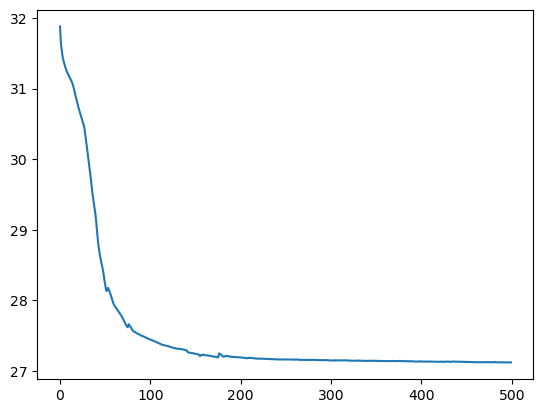

In [9]:
plt.plot(all_losses)

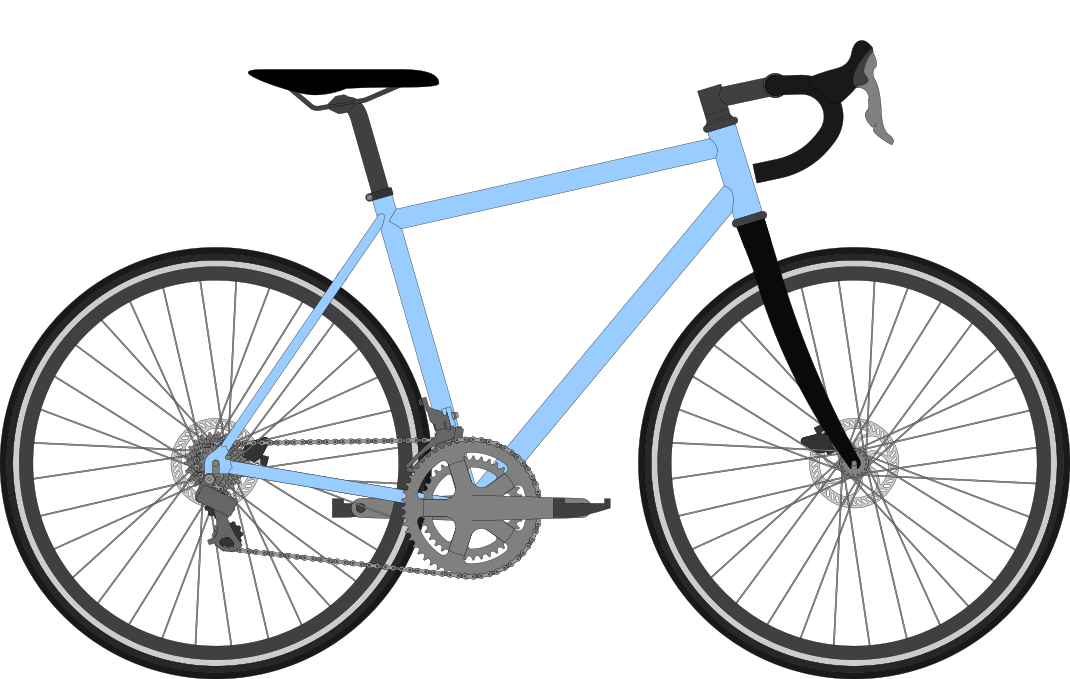

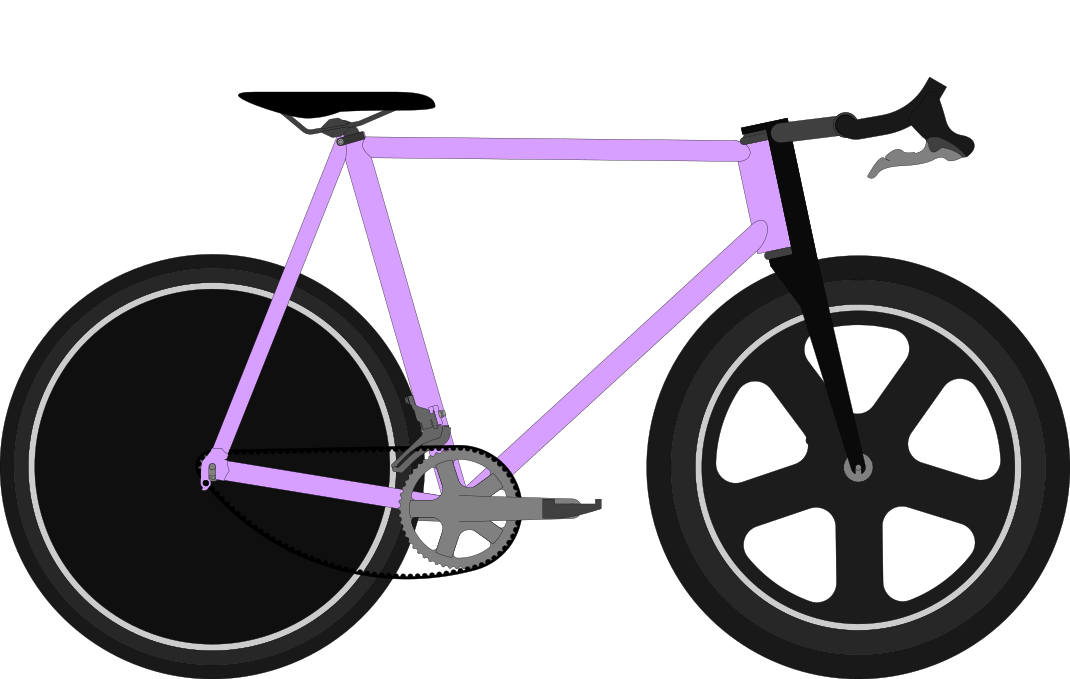

In [10]:
from bikebench.rendering import rendering
renderer = rendering.RenderingEngine(number_rendering_servers = 1, server_init_timeout_seconds=120)

#Initial
res = renderer.render_clip(steps_df.iloc[0])
svg = res.image_bytes
from IPython.display import SVG, display
display(SVG(svg))

xml = res.xml_file

#Final
res = renderer.render_clip(steps_df.iloc[-1])
svg = res.image_bytes
from IPython.display import SVG, display
display(SVG(svg))

In [11]:
frame_step_size = 6
idx = np.r_[np.arange(0, len(steps_df), frame_step_size), len(steps_df) - 1]
idx = np.unique(idx) 

steps_subset = steps_df.iloc[idx].reset_index(drop=True)
mp4 = animation.render_to_animation(steps_subset, fps=10, mp4_filename="aesthetics.mp4")

Rendering frames: 100%|██████████| 85/85 [01:55<00:00,  1.36s/it]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1070, 679) to (1072, 688) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
